# Applying GrandPrix on single-cell RNA-seq of ~68k peripheral blood mononuclear cells (PBMCs).
_Sumon Ahmed_, 2018

This notebooks describes the flexible architecture of the GrandPrix by extending it to 2-D latent spaces. Models optimising and fixing the inducing points are examined. 

In [1]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix

## Helper function

__MapTo01__ converts everything between [0,1]


In [2]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))

## Data description

[Zheng et al. (2017)](https://www.ncbi.nlm.nih.gov/pubmed/28091601) have presented a droplet-based technology that enables 3' messenger RNA (mRNA) digital counting to encapsulate tens of thousands of single cells per sample. They have assayed ~68k peripheral blood mononuclear cells (PBMCs) demonstrating the suitability of single-cell RNA-seq technology to characterize characterise large immune cell populations.

The __Zheng_M_1000.csv__ file contains the expression profiles of top 1000 differentially expressed genes normalised and filtered by using [zheng17 recipe](https://github.com/10XGenomics/single-cell-3prime-paper/tree/master/pbmc68k_analysis) used in the paper [Zheng et al. (2017)](https://www.ncbi.nlm.nih.gov/pubmed/28091601).

In [3]:
Y = pd.read_csv('../data/droplet_68k/Zheng_M_1000.csv', index_col=[0]).values

In [4]:
N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 68579, Genes: 1000


In [5]:
np.random.seed(10)

## 2-D t-SNE visualisation
[Zheng et al. (2017)](https://www.ncbi.nlm.nih.gov/pubmed/28091601) applied k-means clustering algorithms on first $50$ principal components to identify $10$ distinct clusters. They used t-SNE to visualise these $10$ clusters in a two-dimensional projection. We have used these 2-D latent spaces from t-SNE to initialise our model.

The __tsne.csv__ file contains the 2D tsne space along with cluster label of each cell.

In [18]:
tsne_2D = pd.read_csv('../data/droplet_68k/tsne.csv', index_col=0)
tsne_2D.head()

,X1,X2,cls_id,k
1,7.578376,0.642549,CD8+ Cytotoxic T,6
2,2.864957,-25.630973,CD8+/CD45RA+ Naive Cytotoxic,4
3,-6.033593,11.663585,CD4+/CD25 T Reg,3
4,1.832137,26.058027,CD19+ B,7
5,-16.583451,-16.572102,CD4+/CD25 T Reg,2


### Clusters labels

In [26]:
labels = np.sort(np.unique(tsne_2D['k']))
print('Distinct Cluster labels: ',labels)

Distinct Cluster labels:  [ 1  2  3  4  5  6  7  8  9 10]


In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
from utils import plot_XY
plt.rcParams['axes.prop_cycle'] = prop_cycle
labels = [ 1,  2,  3,  4,  5,  6,  7, 9, 10, 8]

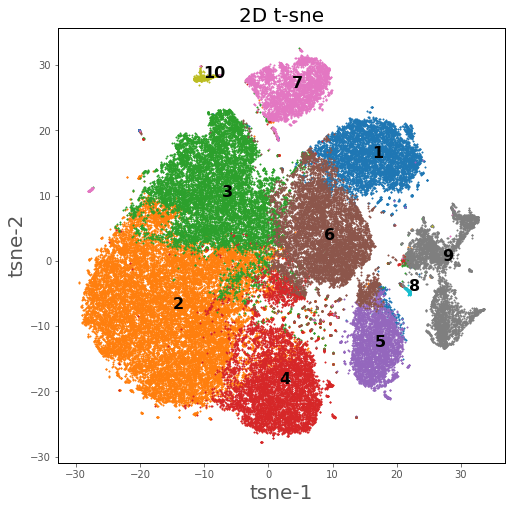

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 8))
plt.subplot(1, 1, 1)
plot_XY(X=tsne_2D['X1'], Y=tsne_2D['X2'], title='2D t-sne', data_labels=tsne_2D['k'],
        label_order=labels, ms=2, xlabel='tsne-1', ylabel='tsne-2')

## Initialise the model using the 2-D tsne space

In [27]:
Q = 2 # Latent dimensions
X_mean = np.zeros((N, Q)) # initialisation of latent_mean 
X_mean[:, 0] = MapTo01(tsne_2D['X1'].values)
X_mean[:, 1] = MapTo01(tsne_2D['X2'].values)

## Initialise the Inducing points
Inducing points have been initialised using the Latent Hypercube Sampling (LHS)(McKay et al., 1979; Larson et al., 2005). LHS is a statistical method that gives a near random sample from a multi-dimensional distribution.

__init_inducing.csv__ file contains $100$ sample points using the package [LHS-MDU](https://github.com/sahilm89/lhsmdu).

In [29]:
indPoints = pd.read_csv('../data/droplet_68k/init_inducing.csv', index_col=[0])
M = 60 # Number of inducing points
Z = np.zeros((M, Q)) # initialisation of inducing input points 
Z[:, 0] = np.random.permutation(indPoints['D1'].values)[:M]
Z[:, 1] = np.random.permutation(indPoints['D2'].values)[:M]

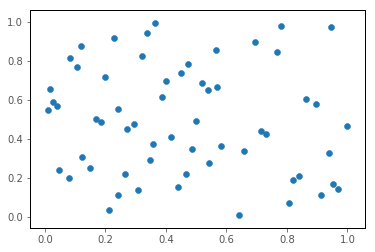

In [30]:
plt.scatter(Z[:, 0], Z[:, 1])

## Model optimising the inducing points

The model optimises variational parameters and hyperparameters simultaneously. Following arguments have been passed to initialize the model.

-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __n_latent_dims__: _int_. Number of latent dimentions to compute.


-  __n_inducing_points__: _int_. Number of inducing points.


-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.


-  __inducing_inputs__: _array-like, shape_ _n_\__inducing_\__points_ x 1. Inducing input variables in the space of latent variables. 


-  __display__: _bool_. Print convergence messages if set to True.

In [13]:
X, var = GrandPrix.fit_model(data=Y, n_latent_dims=Q, n_inducing_points = M,
                                    latent_mean=X_mean.copy(), inducing_inputs=Z.copy(), display=True)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96842542.281688
  Number of iterations: 24
  Number of functions evaluations: 28


## Model fixing Inducing points

To fix the inducing points we have passed a list of parameters that we do not want to optimise.

-  __fix_parameters__: _list_. List of the parameters and hyperparameters we want to fix.


-  __jitter__: _float_. A diagonal jitter to ensure numerical stability. 

In [14]:
X_fixed_ip, var_fixed_ipp = GrandPrix.fit_model(data=Y, n_latent_dims=Q, n_inducing_points = M,
                                    latent_mean=X_mean.copy(), inducing_inputs=Z.copy(), 
                                    fix_parameters=['inducing_inputs'], jitter_level=1e-5, display=True)

sumon
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97000952.838369
  Number of iterations: 28
  Number of functions evaluations: 32


## Visualise the 2-D GPLVM space

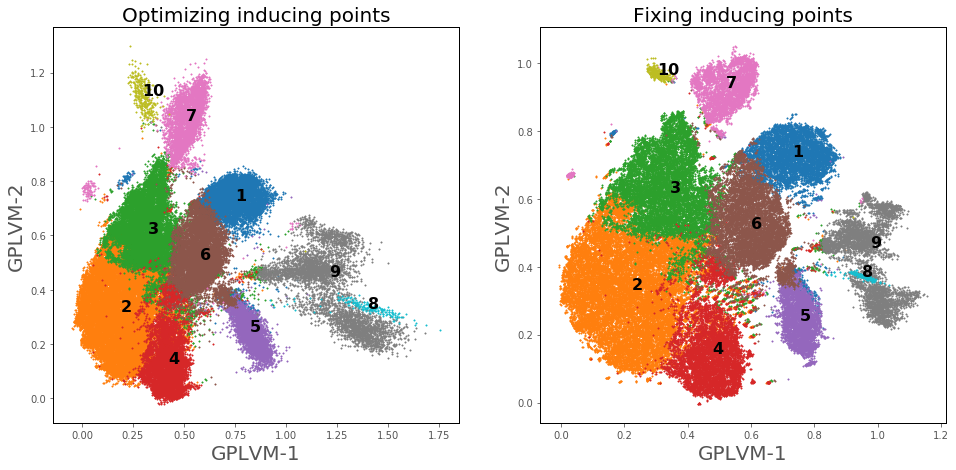

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(X[:,0], X[:,1], title='Optimizing inducing points', data_labels=tsne_2D['k'], label_order=labels, ms=2, xlabel='GPLVM-1')
plt.subplot(2, 2, 2)
plot_XY(X_fixed_ip[:,0], X_fixed_ip[:,1], title='Fixing inducing points', data_labels=tsne_2D['k'], label_order=labels, ms=2, xlabel='GPLVM-1')

## Adjusted rand index (ARI) Comparison

Adjusted rand index (ARI) (Hubert and Arabie, 1985) represents a similarity between two clusterings.The ARI has a value near to 0.0 if the cluster labelling is performed randomly and 1.0 for identical clusterings.

In [48]:
# from utilsls import getari_for_latent_space
from beautifultable import BeautifulTable
table = BeautifulTable(max_width=100)

table.column_headers = ["", "t-SNE", "BGPLVM optimising inducing points", "BGPLVM fixing inducing points"]
table.append_row(["ARI", "%f"%getari_for_latent_space(tsne_2D[['X1', 'X2']].values, tsne_2D['k'].values), 
                  "%f"%(getari_for_latent_space(X, tsne_2D['k'].values)), 
                  "%f"%(getari_for_latent_space(X_fixed_ip, tsne_2D['k'].values))]) 
table.left_padding_widths["t-SNE"] = 5
table.right_padding_widths["t-SNE"] = 5
table.left_padding_widths[""] = 5
table.right_padding_widths[""] = 5

print(table)

/home/sumon/anaconda3/envs/tensor_15/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-05-10 15:56:17.662488. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


+-------------+---------------+------------------------------------+-------------------------------+
|             |     t-SNE     | BGPLVM optimising inducing points  | BGPLVM fixing inducing points |
+-------------+---------------+------------------------------------+-------------------------------+
|     ARI     |     0.508     |               0.534                |             0.526             |
+-------------+---------------+------------------------------------+-------------------------------+
